# **Objectives**


1.Using  time series analysis to forecast the future demand for the given product (Product_ID: P1).

2.Generate accurate predictions for the next several days.

3.Calculate and implement safety stock levels to account for demand variability and uncertainties.

4.Determine the reorder point, which indicates when to replenish inventory based on forecasted demand and safety stock.

5.Apply the Economic Order Quantity (EOQ) concept to identify the optimal order quantity that minimizes total inventory costs.

6.Define the reorder cycle, representing the time interval between placing orders.









# **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


## **Data pre-processing**

In [3]:
data.columns

Index(['Unnamed: 0', 'Date', 'Product_ID', 'Demand', 'Inventory'], dtype='object')

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
#Droping unnamed  column
data = data.drop(columns=['Unnamed: 0'])

# **In Exploratory Data Analysis (EDA) we  various charts and visualizations to gain a comprehensive understanding of your data.**

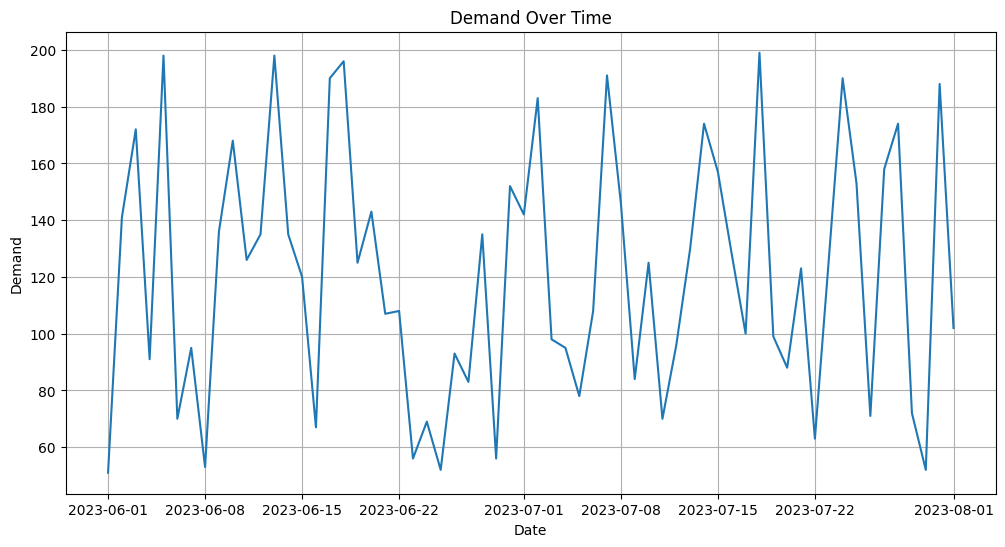

In [5]:
# Line chart for demand data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Demand'])
plt.title('Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True)
plt.show()

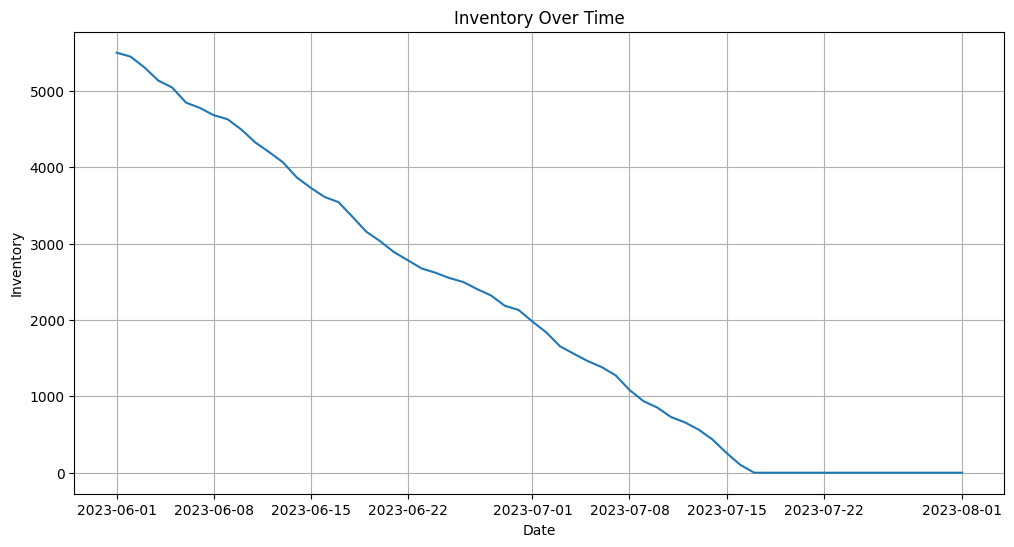

In [6]:
# Line chart for inventory data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Inventory'])
plt.title('Inventory Over Time')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.grid(True)
plt.show()

# **Histograms to understand the distribution of the data**

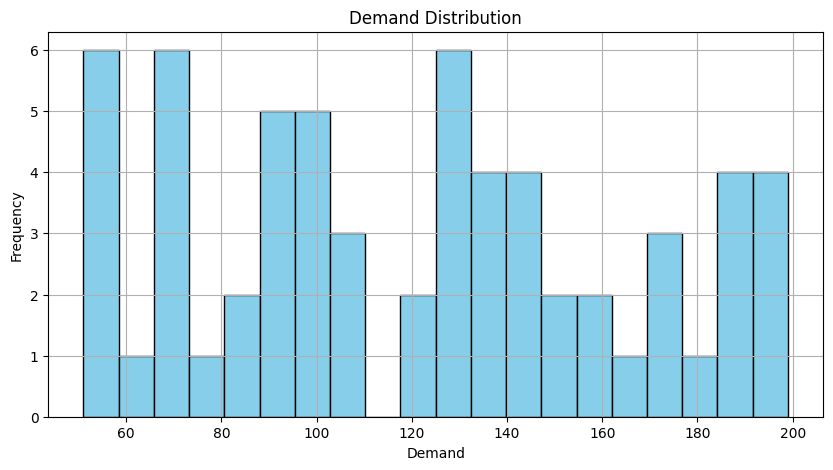

In [7]:
# Histogram for Demand
plt.figure(figsize=(10, 5))
plt.hist(data['Demand'], bins=20, color='skyblue', edgecolor='black')
plt.title('Demand Distribution')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

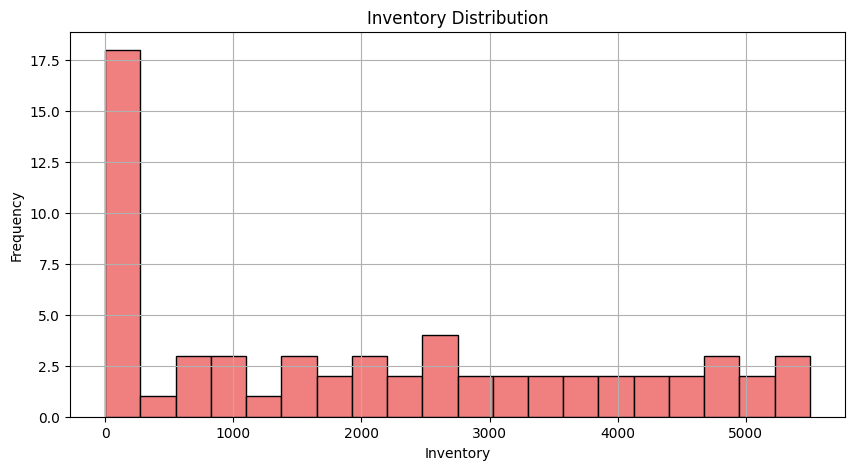

In [8]:
# Histogram for Inventory
plt.figure(figsize=(10, 5))
plt.hist(data['Inventory'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Inventory Distribution')
plt.xlabel('Inventory')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# **Box Plots to visualize summary statistics and identify outliers.**

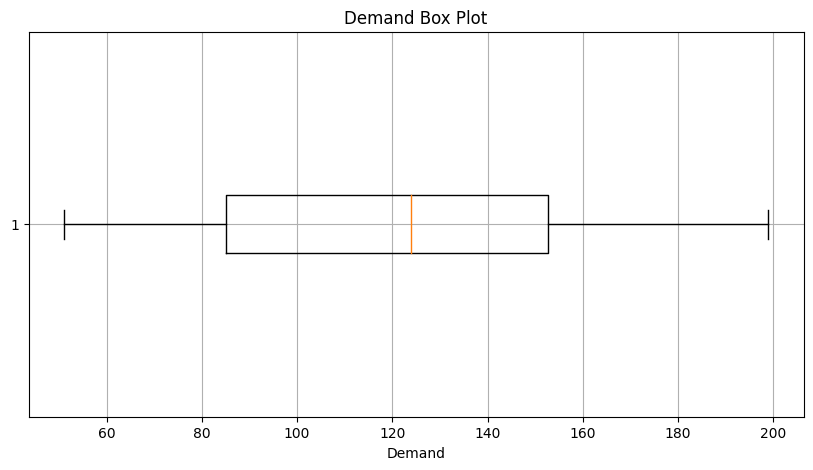

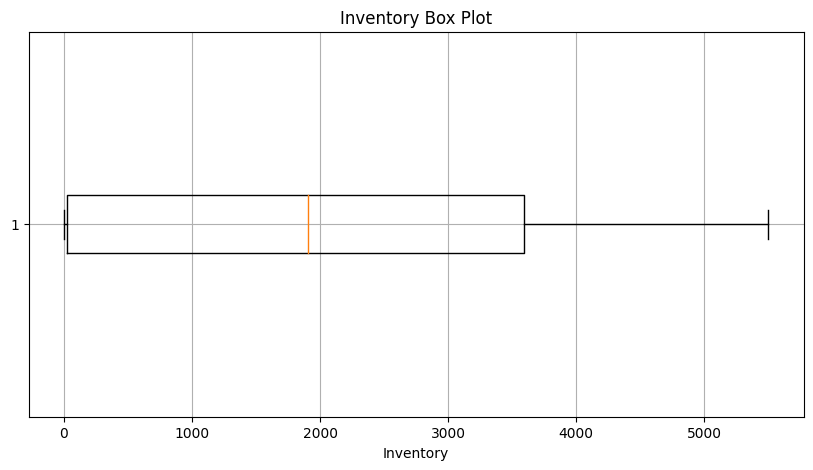

In [9]:
# Box Plot for Demand
plt.figure(figsize=(10, 5))
plt.boxplot(data['Demand'], vert=False)
plt.title('Demand Box Plot')
plt.xlabel('Demand')
plt.grid(True)
plt.show()

# Box Plot for Inventory
plt.figure(figsize=(10, 5))
plt.boxplot(data['Inventory'], vert=False)
plt.title('Inventory Box Plot')
plt.xlabel('Inventory')
plt.grid(True)
plt.show()


Time series decomposition is a statistical technique used to break down a time series dataset into its fundamental components: trend, seasonal, and residual. These components help us understand the underlying patterns and variations within the time series data. Let's explain each component:

1.Trend Component: The trend component represents the long-term direction or movement in the data. It captures the overall upward or downward pattern in the time series. For example, in a sales dataset, if there is a consistent increase or decrease in sales over a period, that would be captured by the trend component.

2.Seasonal Component: The seasonal component represents recurring patterns or cycles within the data that repeat at fixed intervals. These patterns are usually related to specific seasons, months, or days of the week. For example, in retail sales data, there might be a seasonal pattern where sales increase during the holiday season each year.

3.Residual Component (or Error Component): The residual component represents the random and irregular fluctuations in the data that cannot be attributed to the trend or seasonal patterns. It includes noise, one-time events, and unexplained variations. Analyzing the residual component can help identify unusual occurrences or outliers in the data.

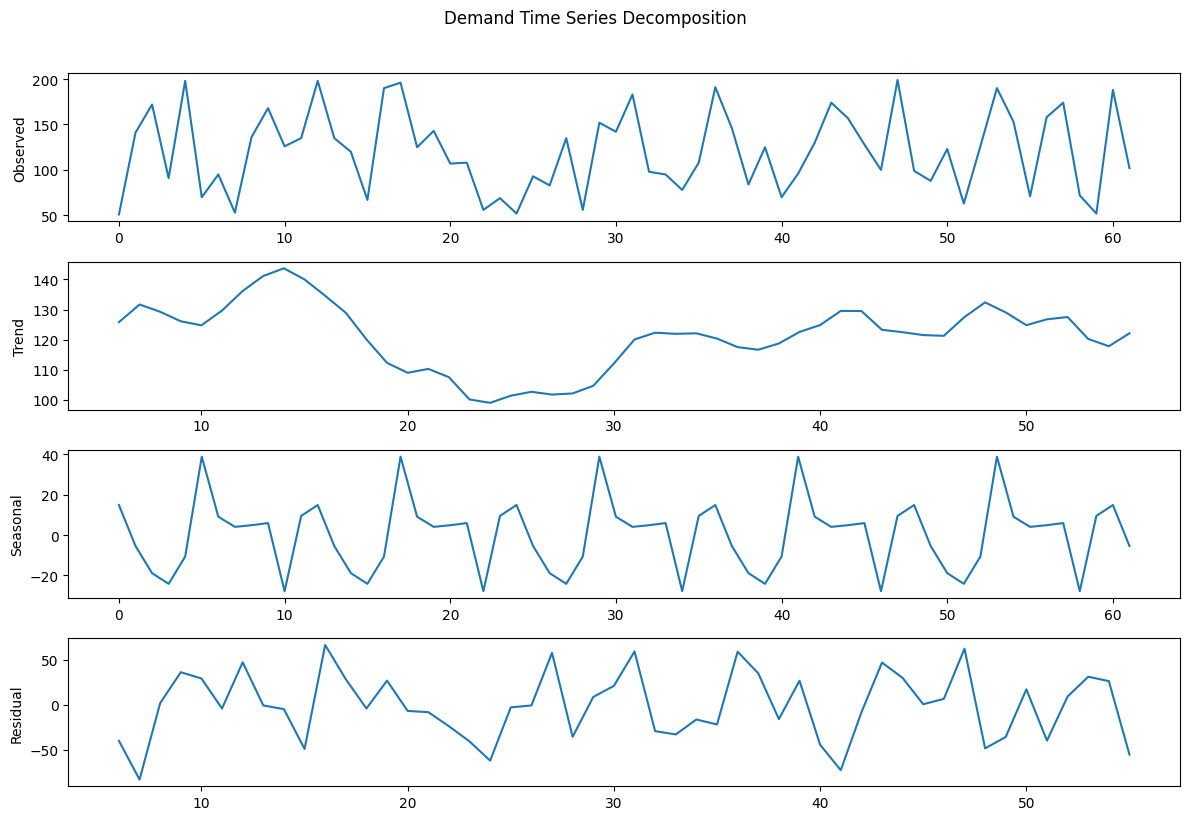

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose Demand
result_demand = seasonal_decompose(data['Demand'], model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result_demand.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
result_demand.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
result_demand.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
result_demand.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
plt.suptitle('Demand Time Series Decomposition', y=1.02)
plt.tight_layout()
plt.show()




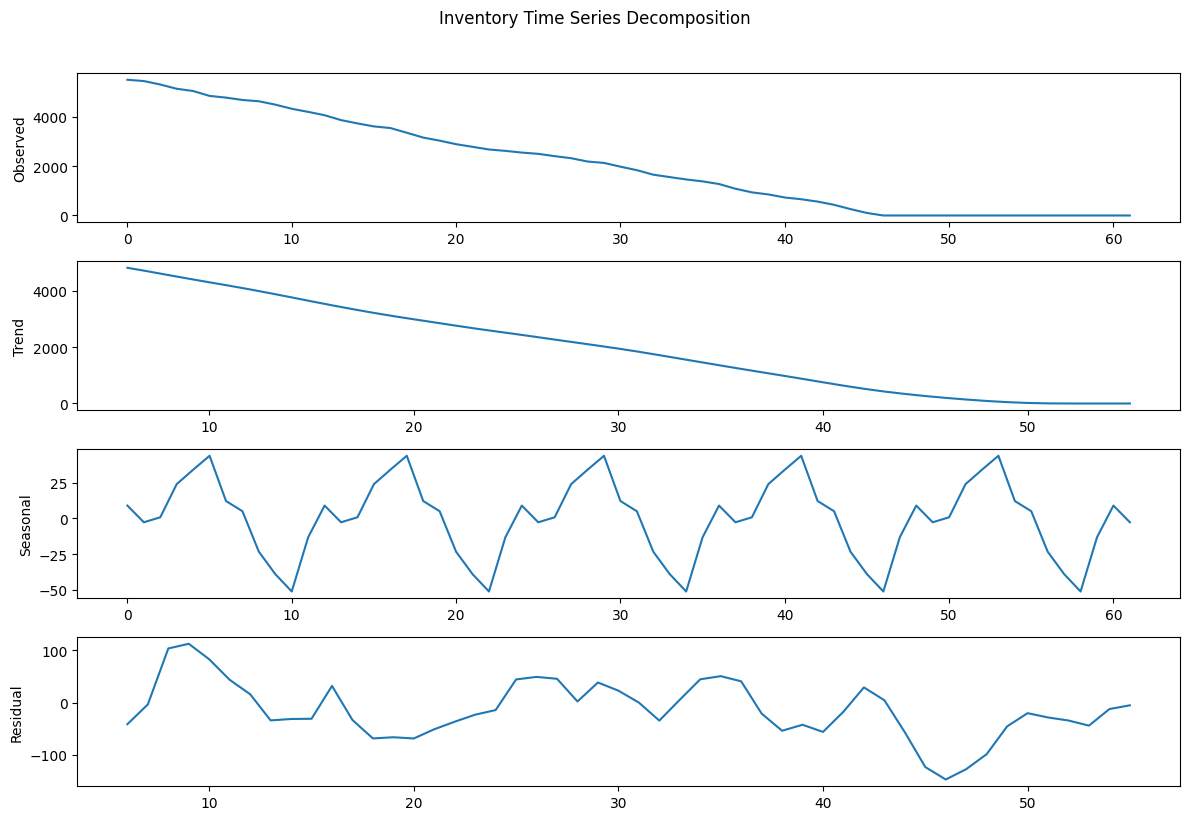

In [13]:
# Decompose Inventory
result_inventory = seasonal_decompose(data['Inventory'], model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result_inventory.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
result_inventory.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
result_inventory.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
result_inventory.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
plt.suptitle('Inventory Time Series Decomposition', y=1.02)
plt.tight_layout()
plt.show()

#   Demand forecasting

Breakdown of the code:

1.First we converted the 'Date' column to a datetime format and set it as the index of your DataFrame, making it suitable for time series analysis.

2.Next we   calculated the differenced series using .diff() to remove any trend and make the series stationary.

3.Then plotted the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots for the differenced time series.

These plots will help you visually inspect where the autocorrelation and partial autocorrelation values are significant, which will guide you in selecting appropriate values for p and q for your SARIMA model. The significant lags in these plots indicate potential orders for autoregressive and moving average terms.

Now, based on the ACF and PACF plots, we can make informed decisions about the values of p and q for our SARIMA model. If you see significant spikes or decay in the plots at certain lags, you can consider those lags as potential values for p and q, respectively.

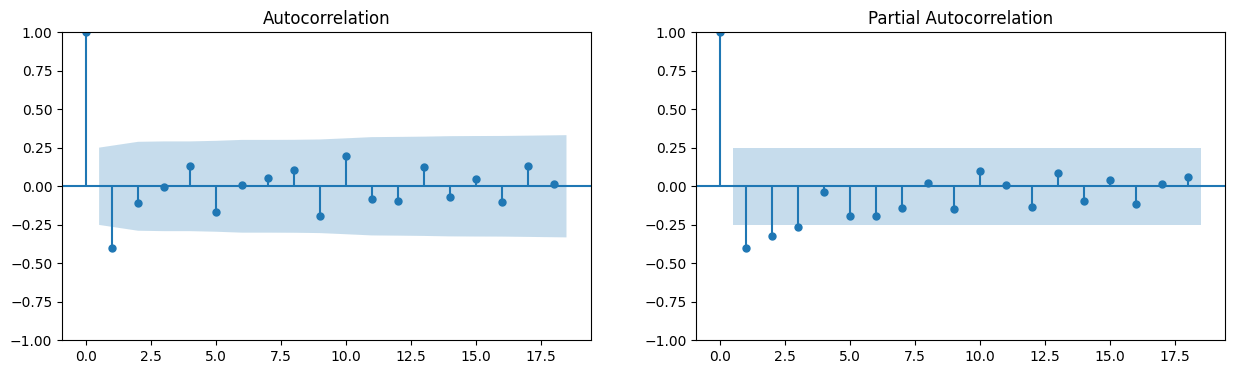

In [21]:
data['Date'] = pd.to_datetime(data['Date'],
                                     format='%Y/%m/%d')
time_series = data.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()


# The value of p, d, and q will be 1, 1, 1

In [22]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


# **Inventory Optimization**

In [25]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory)
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)



Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001



**Code Explanation:**

1. **Creating Future Dates:**
   - `future_dates` is created using `pd.date_range` to represent future dates for which we want to make inventory predictions. It starts from the last date in the `time_series` plus one day and continues for `future_steps` days with a daily frequency ('D').

2. **Creating Forecasted Demand Series:**
   - `forecasted_demand` is created as a Pandas Series with the predicted demand values and the corresponding date indices from `future_dates`. These predictions are obtained from your SARIMA model.

3. **Setting Initial Inventory, Lead Time, and Service Level:**
   - `initial_inventory` is set to 5500 units, representing the initial inventory level.
   - `lead_time` is set to 1 day, which is the number of days it takes to replenish inventory.
   - `service_level` is set to 0.95, representing the desired service level (probability of not stocking out).

4. **Calculating Order Quantity Using Newsvendor Formula:**
   - The Newsvendor formula is used to calculate the optimal order quantity (`order_quantity`). It involves:
     - Calculating the critical ratio (z) based on the service level and the distribution of forecasted demand.
     - Adding z to the mean forecasted demand to determine the order quantity.

5. **Calculating Reorder Point:**
   - The reorder point (`reorder_point`) is calculated using the formula: Reorder Point = Mean Demand * Lead Time + z. It represents the inventory level at which an order should be placed to avoid stockouts.

6. **Calculating Safety Stock:**
   - The safety stock (`safety_stock`) is determined by subtracting the mean demand multiplied by lead time from the reorder point. It represents the extra inventory maintained as a buffer against demand variability.

7. **Calculating Holding and Stockout Costs:**
   - `holding_cost` is set to 0.1, representing the cost of holding one unit of inventory for one day.
   - `stockout_cost` is set to 10, representing the cost incurred per unit for stockouts.
   - `total_holding_cost` is calculated as the holding cost for the initial inventory plus half of the order quantity.
   - `total_stockout_cost` is calculated as the stockout cost for any shortfall between initial inventory and demand during lead time.

8. **Calculating Total Cost:**
   - The total cost (`total_cost`) is the sum of the holding cost and stockout cost.

**Output Explanation:**

The output provides information about the optimized inventory policy based on the New vendor approach and the specified parameters:

- **Optimal Order Quantity**: 236 units - This is the order quantity that minimizes the total cost, considering the service level and forecasted demand.

- **Reorder Point**: 235.25 units - This is the inventory level at which you should place an order to avoid stockouts. It accounts for lead time and desired service level.

- **Safety Stock**: 114.45 units - Safety stock acts as a buffer to absorb demand variability and prevent stockouts.

- **Total Cost**: 561.80 (in some unspecified currency) - This is the total cost incurred, considering both holding costs (cost of carrying inventory) and stockout costs (cost of lost sales due to stockouts).

These values provide insights into how to optimize inventory management, balancing the costs associated with holding excess inventory and the costs associated with stockouts, while achieving a specified service level. The specific values may vary depending on your business context and parameter settings, but this example illustrates the methodology for inventory optimization.